<a href="https://colab.research.google.com/github/kameda-yoshinari/DataAlgo2020/blob/master/DataAlgo2020_007(%E6%9C%80%E9%95%B7%E7%B5%8C%E8%B7%AF%E5%95%8F%E9%A1%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1. 最長経路問題

ここでは最長経路問題とそれを解くアルゴリズムについて学ぶ．

**いつもの約束**  
１つのコードセルだけの実行は Ctrl + Enter．  
エディタで「インデント幅（スペース）は4で表示」「行番号を表示」「インデントガイドを表示」．  
内部では日本語はUTF-8で表現されている．


# 準備

インスタンスに接続し起動する．  
下記の手順でGoogle Driveをマウントする．  
マウント先に移動し，作業フォルダとする．  
これによって，インスタンスがリセットされてもGoogle Drive内にファイルが保存されるようにする．

In [0]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')

In [0]:
!echo "今回の作業用フォルダを作成しそこに移動します"
%cd /content/drive/My\ Drive/
%mkdir -p 202004_DataAlgo/DA2020_007
%cd       202004_DataAlgo/DA2020_007
!ls
!echo "日本時間表示"
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Japan /etc/localtime
!date

ここでは，グラフ5を利用する．  
頂点数は8．有向グラフ．閉路なし．


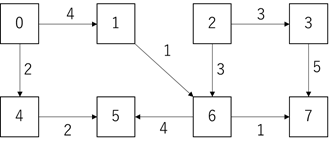

In [0]:
%%writefile graph5.h
// 8 nodes, directed, no cycle.
#define N 8
int edge[N][N] = {
//   0 1 2 3 4 5 6 7
	{0,4,0,0,2,0,0,0}, // 0
	{0,0,0,0,0,0,1,0}, // 1
	{0,0,0,3,0,0,3,0}, // 2
	{0,0,0,0,0,0,0,5}, // 3
	{0,0,0,0,0,2,0,0}, // 4
	{0,0,0,0,0,0,0,0}, // 5
	{0,0,0,0,0,4,0,1}, // 6
	{0,0,0,0,0,0,0,0}  // 7
};

# 最長経路問題概要

**内容**

グラフとして重み付き有向グラフを考える．辺に重みとして数値が付与されている．
本節では，辺の重みは正値とする．
隣接する頂点aと頂点bの間の辺の重みをedge(a,b)で表現する．edge(a,b)は正値である．  

最長経路問題とは，与えられた重み付き有向グラフにおいて，その重みの合計が最も大きい道を求める問題である．なお，頂点Aから頂点Bへの「道」には，同じ頂点は高々一度しか現れないことに注意する．以降，ある道（経路）が与えられた時，その辺の重みの合計のことを経路（道）の重みと呼ぶ．

頂点集合V中のある頂点kについて注目する．
頂点kを到着頂点とする道の中で最も重みのある道の重みをW(k)で表すとする．  
求めたいのは，頂点集合 V の中で最大の W(k_max) であり，それを実現する道の構成である．  

今，ここで，頂点dより上流の全ての頂点sではW(s)がわかっているものとする．  
すると，W(d)は次式によって求められる．  
> W(d) = max ( W(s) + edge(s,d) )   
> ただしsは頂点dに向かって隣接しているすべての頂点  

では「頂点dより上流の全ての頂点sではW(s)がわかっているものとする」ことをどうやって保証すればいいのであろうか．それを保証するのがトポロジカルソーティングである．  

アルゴリズムは３部構成になる．  

1. トポロジカルソーティングを実施する
2. 上流から順に頂点kについて W(k) を求めていく
3. 全頂点について求めた W( ) において最大の値 W(k_max) を求める

**実装**

トポロジカルソーティングについては前のプログラムをそのまま流用する．

参考までに，グラフ5では最長経路の重みは 9 となる．  
Longest Path Value = 9  
5 <- 6 <- 1 <- 0 <- Go

# 最長経路問題を解くプログラム

**目標**

無閉路の有向グラフにおいて最長経路の重みとその経路を求める．

**説明**

アルゴリズムは３部構成になる．

1. トポロジカルソーティングを実施する
2. 上流から順に頂点kについて W(k) を求めていく
3. 全頂点について求めた W( ) において最大の値 W(k_max) を求める

**コード**

アルゴリズムを３部構成に分けたので，それぞれをユーザ定義関数で実現する．

**備考**

アルゴリズムの3.は2.の中に統合できるが，アルゴリズム説明とプログラム記述を揃えるために別関数で用意している．  
このプログラムでは，最長経路の重みを求めるだけでなく，最長経路の構成を表示するために工夫をしている．


In [0]:
%%writefile longestpath_J.c
// Topological Sorting
//    2020/05/24 kameda
#include <stdio.h>
#include "graph5.h"

typedef struct {int W; int src;} ppath;

int tsort[N];  // トポロジカルソーティング結果を記録するための配列
int num_tsort = 0; // 記録済の頂点数
ppath path[N]; // 経路を参照できるようにするためのリンクトリスト風配列

int listed[N];  // 0 未, 1 済

// 深さ優先探索本体 / 再帰呼出
void dfs(int CurrentRoom){
    int RoomToCheck;

	// 処理済みであることを記録
	listed[CurrentRoom] = 1;

    // 次にどの頂点を列挙していくか検討
	for (RoomToCheck = 0; RoomToCheck < N; RoomToCheck++) {
        if (edge[CurrentRoom][RoomToCheck] != 0 && listed[RoomToCheck] == 0) 
			dfs(RoomToCheck);
	}

	// トポロジカルソーティング
	// printf("●●列挙： %d\n", CurrentRoom);
	tsort[num_tsort] = CurrentRoom;
	num_tsort++;

	return;
}

// それぞれの頂点での最長経路（最長経路を解くための探索）
void findlongest (void) {
	int p; // トポロジカルソート結果配列 tsort 上での注目箇所
	int d; // 検討する頂点の番号

	// Cleaning up
	// 最長経路を計算するための配列を初期化
	{
		int i;
		for (i = 0; i < N; i++) {
			path[i].W = 0; // the largest cost of the paths that terminates at vertex i
			path[i].src = -1; // the src vertex that gives us the path of the largest cost
		}
	}
	
	// Take up a vertex from the end of tsort[] (i.e. starting from source vertices)
	// トポロジカルソートの順に上流側から頂点を処理
	for (p = N-1; p >= 0; p--) {
		int s;
		d = tsort[p];
		for (s = 0; s < N; s++) {
			if (edge[s][d] > 0 && path[s].W + edge[s][d] > path[d].W) {
				path[d].W = path[s].W + edge[s][d];
				path[d].src = s;
			}
		}
	}

	return;
}

// 最長経路を求めて表示
void findfinalsolution (void) {
  	int LVertex; // 解：最長経路の到着頂点（終点）
	int i;

	// Tentative vertex candidate (of longest path)
	// 頂点0を仮解とする
	LVertex = 0;

	// find the actual (destination) vertex
	// 最長経路の頂点 LNode を探す
	for (i = 1; i < N; i++) {
		if (path[i].W > path[LVertex].W)
			LVertex = i;
	}

	// Show the longest path
	printf("Longest Path Value = %d\n", path[LVertex].W);
	for (i = LVertex; i >= 0; i = path[i].src)
		printf("%d <- ", i);
	printf("Go\n");
}

int main(int argc, char *argv[]){
	int StartingNode;
	int i;

	printf("1. トポロジカルソーティングを開始します．\n");
	for (StartingNode = 0; StartingNode < N; StartingNode++) {
		if (listed[StartingNode] == 0) {
			dfs(StartingNode);
		}
	}
	printf("T.Sort 結果 : ");
	for (i = 0; i < N; i++)
		printf("%d ", tsort[i]);
	printf("\n");

	printf("2. 最長経路を解くための探索を開始します． \n");
	findlongest();

	printf("3. 最長経路を求めて表示します． \n");
	findfinalsolution();

  return 0;
}


コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -o  longestpath_J longestpath_J.c

実行．

In [0]:
!./longestpath_J

# 節末課題

1. 最長経路の表示の仕組み  
最長経路の頂点の並びを表示する仕組みについて，longestpath_J プログラムに即して説明せよ．
このとき，構造体ppathのメンバ src に格納されている値について言及すること．

2. 計算量  
最長経路問題を解く longestpath_J プログラムの時間計算量と空間計算量を議論せよ．

3. 閉路の扱い  
最長経路問題において，与えるグラフには閉路が存在していないと仮定した．その理由の妥当性を議論せよ．

4. 閉路の実際上の扱い  
本節の longestpath_J プログラムでは，実際には閉路が含まれるグラフを与えても実行すると結果が出てしまう．
これは，閉路があると最長経路が解として得られないはず，ということと矛盾する．
本プログラムで実行結果がでるのは，グラフの解釈を都合のよいように勝手に変えているからと考えることができる．  
それでは，本プログラムでは，閉路が存在するとき，それをどう解釈しているのか，説明を試みよ．


# 出典

筑波大学工学システム学類  
データ構造とアルゴリズム  
担当：亀田能成  
2020/06/03.
